In [67]:
import os
import time
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
#%matplotlib widget
import matplotlib
from PIL import Image
from progressbar import ProgressBar
from xml.dom import minidom
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import pprint;pp = pprint.PrettyPrinter(depth=4)
import copy
np.random.seed(0)

COLOR = 'red'
res = (np.array([1920,1080])/4).astype(int)
padding = [200,200] # part of image discarded
print('Network Input Resolution: ',res)

### Dataset Utils

In [86]:
def load_one_image(img_path,annot_path, plot=False):
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    annot = minidom.parse(annot_path)
    objs = annot.getElementsByTagName('object')
    objs_parsed = []
    for obj in objs:  # For each label in image
            o = dict()
            o['name'] = obj.getElementsByTagName(
                'name')[0].firstChild.nodeValue
            if(int(obj.getElementsByTagName('is_incorrect')[0].firstChild.nodeValue) != 0):
                print('incorrect object')
                continue
            if 'armor' in o['name']:
                o['armor_class'] = int(obj.getElementsByTagName(
                    'armor_class')[0].firstChild.nodeValue)
                o['armor_color'] = obj.getElementsByTagName(
                    'armor_color')[0].firstChild.nodeValue
            if len(obj.getElementsByTagName('difficulty')) != 0:
                o['difficulty'] = int(obj.getElementsByTagName(
                    'difficulty')[0].firstChild.nodeValue)
            bb = obj.getElementsByTagName('bndbox')[0]
            o['bbmin'] = np.array([float(bb.getElementsByTagName('xmin')[0].firstChild.nodeValue),
                                   float(bb.getElementsByTagName('ymin')[0].firstChild.nodeValue), ])
            o['bbmax'] = np.array([float(bb.getElementsByTagName('xmax')[0].firstChild.nodeValue),
                                   float(bb.getElementsByTagName('ymax')[0].firstChild.nodeValue), ])
            objs_parsed.append(o)
            if plot:
                cv2.rectangle(image,
                              tuple(o['bbmin'].astype(int)),
                              tuple(o['bbmax'].astype(int)),
                              color=(255, 255, 0), thickness=2)
    if plot:
        #pp.pprint(objs_parsed)
        plt.figure(figsize=[18, 18])
        plt.imshow(image)
        plt.title(img_path+'\n'+annot_path)
    return image,objs_parsed
    
def load_dataset_file_list_from(
        official_dataset_paths='./data/DJI ROCO/'):
    official_dataset_paths = list(
        filter(lambda x: os.path.isdir(x), glob(official_dataset_paths + '*')))
    print('loading from: ', official_dataset_paths)

    img_names = []
    annot_names = []
    for path in official_dataset_paths:
        annots = glob(path + '/image_annotation/*')
        imgs = list(
            map(lambda x: x.replace('_annotation', '').replace('xml', 'jpg'),
                annots))
        img_names += imgs
        annot_names += annots
    print(f'{len(annot_names)} annotations, {len(img_names)} images found')
    '''
    imgs = []
    annots = []
    for i in ProgressBar()(range(min(num, len(annot_names)))):  # For each image
        image,annot = load_one_image(img_names[i],annot_names[i],plot)
        imgs.append(image)
        annots.append(annot)            
    '''
    return img_names, annot_names

loading from:  ['./data/DJI ROCO/robomaster_Central China Regional Competition', './data/DJI ROCO/robomaster_Final Tournament', './data/DJI ROCO/robomaster_North China Regional Competition', './data/DJI ROCO/robomaster_South China Regional Competition']
10368 annotations, 10368 images found


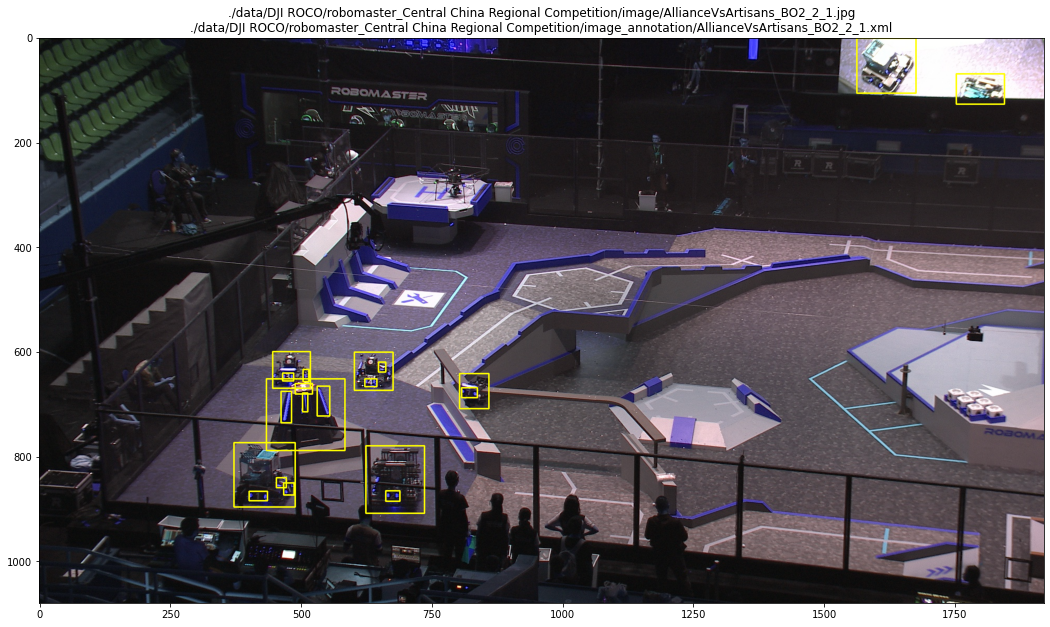

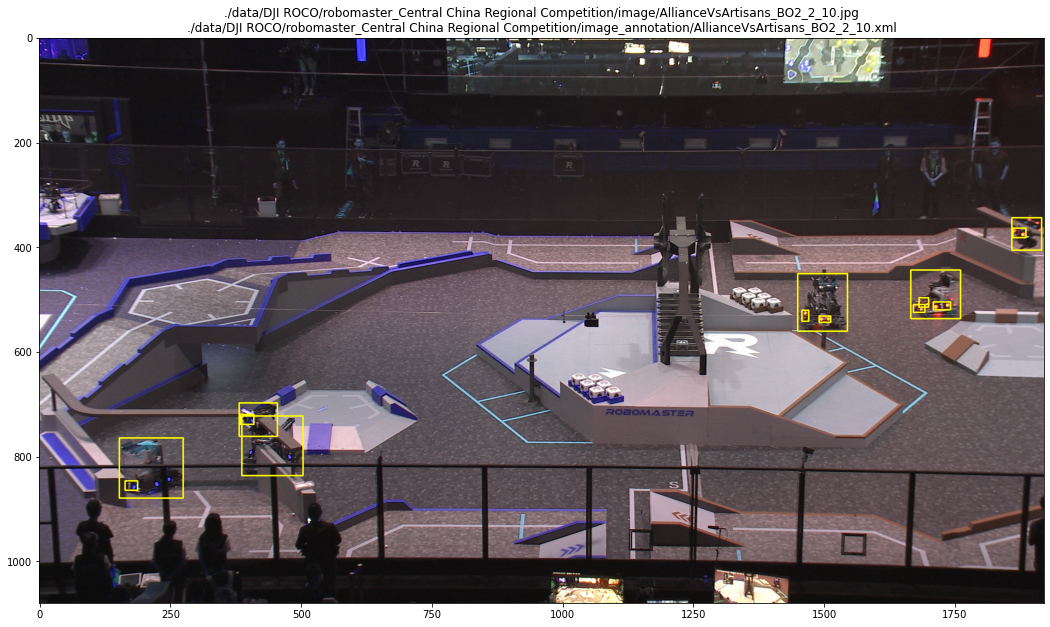

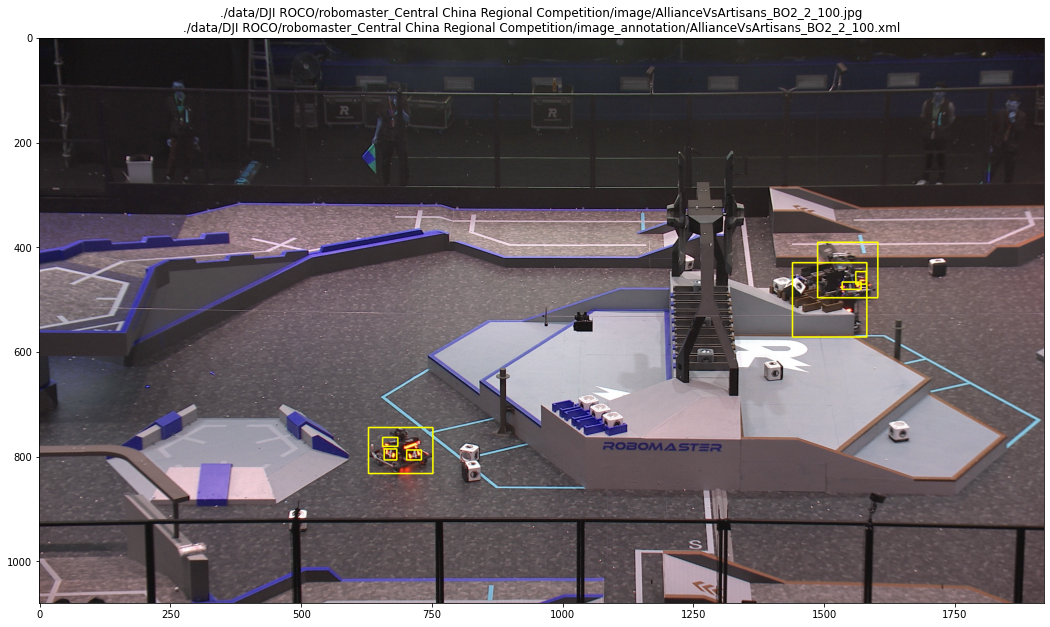

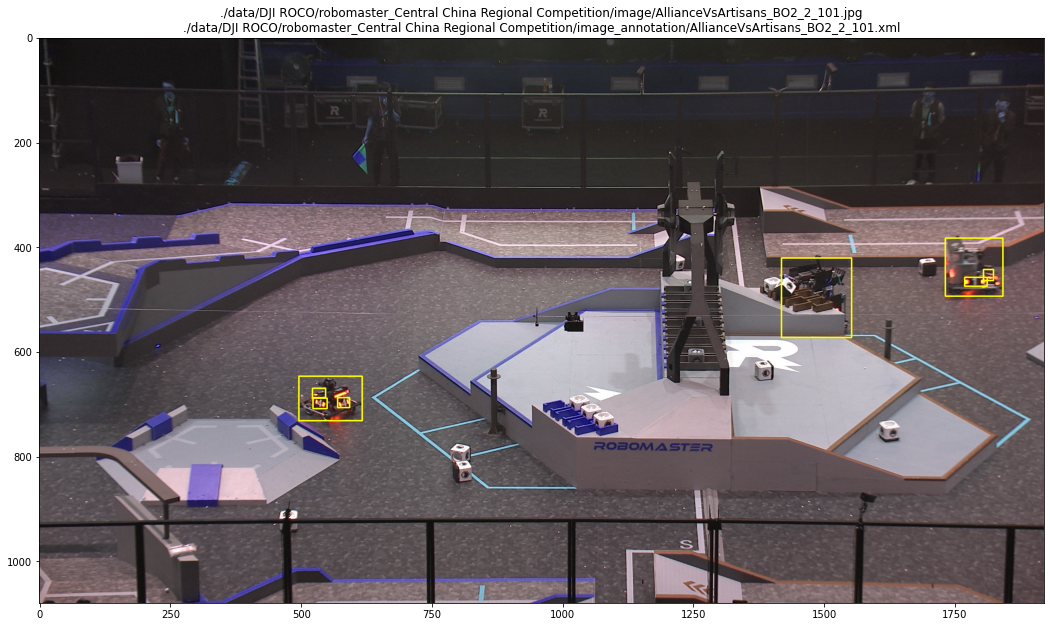

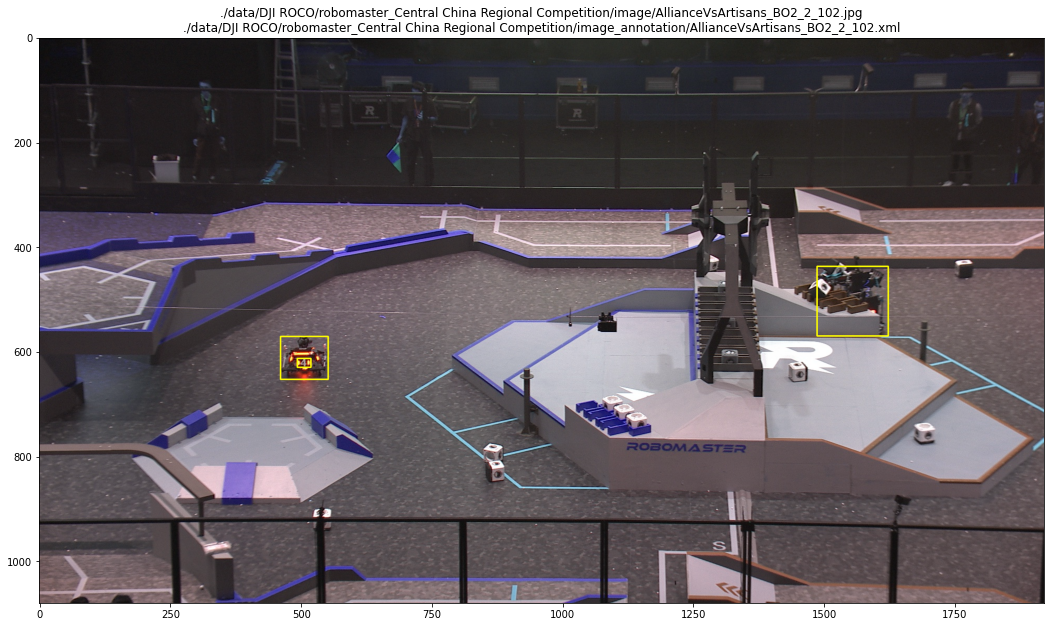

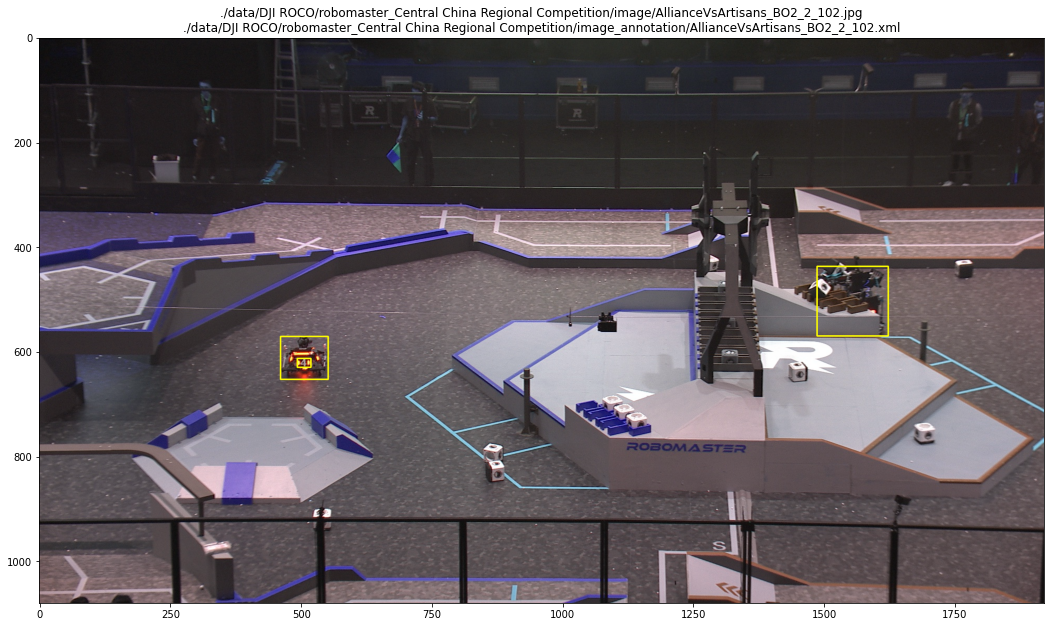

In [87]:
img_names, annot_names = load_dataset_file_list_from()
for i in range(5):
    image,annot = load_one_image(img_names[i],annot_names[i],plot=True)
image,annot = load_one_image(img_names[i],annot_names[i],plot=True)

Network Input Resolution:  [480 270]
{'zoom': 2.4199652061425603, 'start': (866, 385)}
[{'name': 'armor', 'armor_class': 3, 'armor_color': 'red', 'bbmin': array([147.01893619,  59.26918284]), 'bbmax': array([164.65443263,  66.93684259])}, {'name': 'armor', 'armor_class': 3, 'armor_color': 'red', 'bbmin': array([155.45251493,  68.47049554]), 'bbmax': array([168.49007748,  78.43833223])}]


'Done'

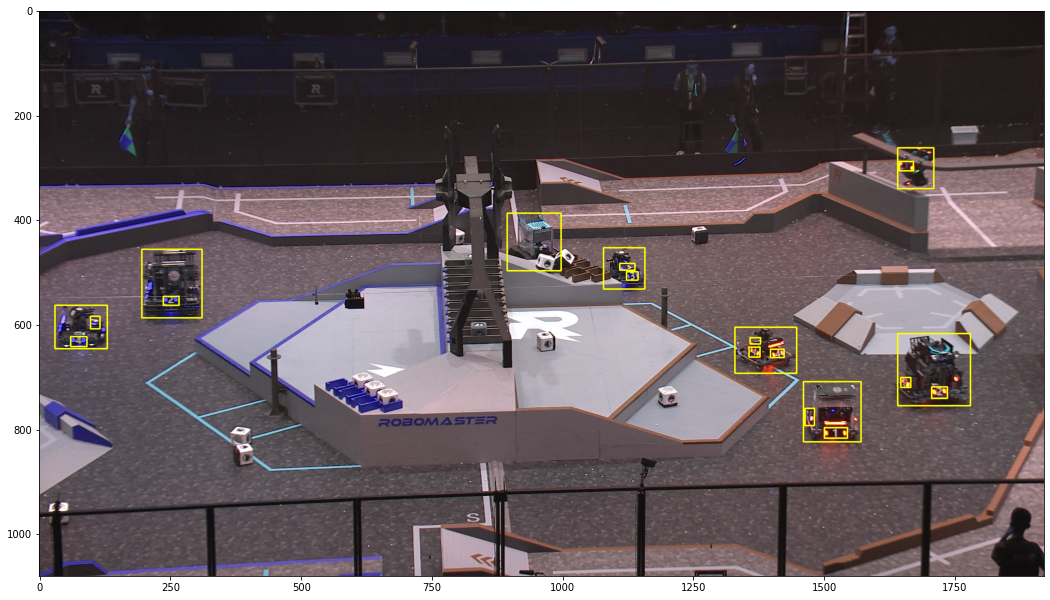

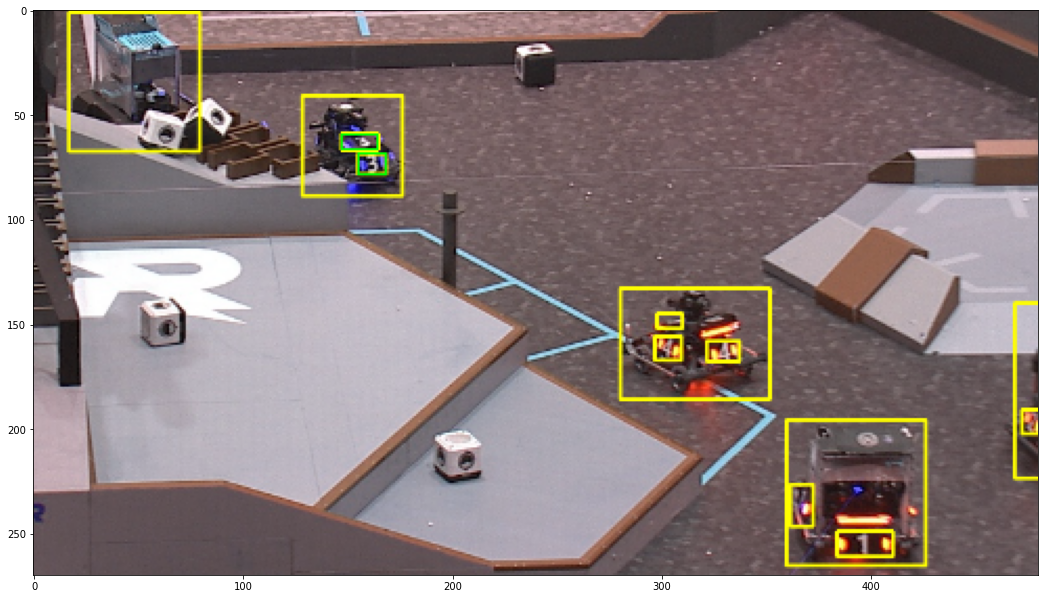

In [61]:
def get_random_spec():
    spec = dict()
    spec['zoom'] = np.random.uniform(1.5,4)
    #spec['zoom'] = 2
    '''
        x->
       y|----------------------------------|
       l|                                  |
       v|  start(x,y)----------|           |
        |  |                   |           |
        |  |                   |           |
        |  --------------------|           |
        |                                  |
        |--------------------------------- |
    '''
    start_x = int(np.random.uniform(padding[0],1920-padding[0]-1920/spec['zoom']))
    start_y = int(np.random.uniform(padding[1],1080-padding[1]-1080/spec['zoom']))
    spec['start'] = (start_x,start_y)
    return spec
    
def multi_scale_crop(img,annot,allow_empty=True,plot=False):
    img = img.copy()
    annot = copy.deepcopy(annot)
    for i in range(1000):# Retry at most 100 times
        spec = get_random_spec()
        crop_x = [spec['start'][0],spec['start'][0]+int(1920/spec['zoom'])]
        crop_y = [spec['start'][1],spec['start'][1]+int(1080/spec['zoom'])]
        img_crop = img[crop_y[0]:crop_y[1],crop_x[0]:crop_x[1],:].copy()
        img_crop = cv2.resize(img_crop, tuple(res))
        def shift_bb(o):
            o = copy.deepcopy(o)
            o['bbmin']-=np.array(spec['start'])
            o['bbmax']-=np.array(spec['start'])
            o['bbmin']*=res[1]/(1080/spec['zoom'])
            o['bbmax']*=res[1]/(1080/spec['zoom'])
            return o
        annot_crop = map(lambda o:shift_bb(o), annot)
        annot_crop = filter(lambda o: True
                       and 'armor' in o['name'] and COLOR in o['armor_color']
                       and np.sum(o['bbmin']<0)==0 and np.sum(o['bbmax']<0)==0
                       and o['bbmax'][1]<res[1]
                       and o['bbmax'][0]<res[0]
                       ,annot_crop)
        annot_crop=list(annot_crop)
        if allow_empty or ((not allow_empty) and len(annot_crop)!=0):
            break
    if plot:
        print(spec)
        print(annot_crop)
        for o in annot_crop:
            cv2.rectangle(img_crop,
                tuple(o['bbmin'].astype(int)), tuple(o['bbmax'].astype(int)),
                color=(0, 255, 0), thickness=1)
        plt.figure(figsize=(18,18))
        plt.imshow(img_crop)
    
    return img_crop, annot_crop
    
pair = imgs[19],annots[19]
plt.figure(figsize=(18,18))
plt.imshow(pair[0])
multi_scale_crop(pair[0],pair[1],plot=True,allow_empty=False)
'Done'

### Training/Testing Set Label Generation

In [88]:
annot

[{'name': 'armor',
  'armor_class': 4,
  'armor_color': 'blue',
  'bbmin': array([493.059, 612.241]),
  'bbmax': array([519.674, 629.985])},
 {'name': 'car',
  'difficulty': 2,
  'bbmin': array([1486.69 ,  436.074]),
  'bbmax': array([1622.3 ,  569.15])},
 {'name': 'car',
  'difficulty': 0,
  'bbmin': array([461.374, 570.417]),
  'bbmax': array([552.626, 652.798])}]

In [90]:
train_save_loc = './data/dji_roco_preprocessed/train/'
test_save_loc = './data/dji_roco_preprocessed/test/'
classes = ['car','watcher','base','ignore','armor_red','armor_blue']
def objs_to_txt(annot):
    for o in annot:
        class_name = o['name'] + (('_'+o['armor_color']) if 'armor' in o['name'] else '')
        print(class_name)
        #TODO Bounding box calculations

objs_to_txt(annot)

armor_blue
car
car


### Other

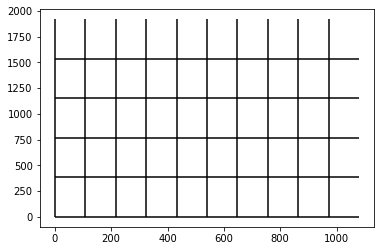

In [58]:
grid_layout = np.array([5,10]) #y,x
def encode_objects_to_label(annot, plot=False): # Assume armor plate only
    annot = copy.deepcopy(annot)
    grid_size = res/grid_layout
    vec = np.zeros([grid_layout[0],grid_layout[1],6*3]) #[w, h, dx, dy, w, color]
    if plot:
        plt.figure()
        for i in range(grid_layout[0]):
            plt.hlines(i*grid_size[0], 0, res[1])
        for i in range(grid_layout[1]):
            plt.vlines(i*grid_size[1], 0, res[0])
encode_objects_to_label(annots[1],plot=True)